# Child in Need Plan (CiNP) LSOA Analysis


# Importing Necessary Libraries

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
color='#702A7D'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

# Define Query to Get Data

In [3]:
query = """
WITH cinp_WithAddress AS (
  SELECT
    cinp.person_id,
    cinp.StartDate,
    cinp.EndDate,
    cinp.YearOfBirth,
    cinp.EthnicOrigin,
    DATE(p.birth_datetime) AS DateOfBirth,
    p.gender_source_value AS Gender,
    a.SOA AS LSOA,
    /* For each cinp row, rank the joined address rows 
       (if any) by DateEventRecorded (converted to DATE) descending */
       
    ROW_NUMBER() OVER (
      PARTITION BY cinp.person_id, cinp.StartDate
      ORDER BY DATE(a.DateEvent) DESC
    ) AS rn
  FROM
    `yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiNP` cinp
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_AddressHistory_New` a
      ON cinp.person_id = a.person_id
      AND DATE(a.DateEvent) <= cinp.StartDate
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.person` p
      ON cinp.person_id = p.person_id
)
SELECT 
  person_id,
  Gender,      
  StartDate,
  EndDate,
  YearOfBirth,
  EthnicOrigin,
  DateOfBirth,
  LSOA
FROM
  cinp_WithAddress
WHERE 
  rn = 1;
"""

## Load Intervention, Boundary, IMD, and Population Data

In [4]:
# Intervention Data
cinp = pandas_gbq.read_gbq(query)

# Boundary Data
boundary_data_filepath = "../data/BradfordBoundaryData/england_lsoa_2021.shp"
bradford_boundary_data = gpd.read_file(boundary_data_filepath)

# IMD Data
imd_filepath = "../data/English IMD 2019/IMD_2019.shp"
imd_data = gpd.read_file(imd_filepath)

# Population Data
population_data_file_path = '../data/Bradford_Children_population_0-17_2021.csv'
population_data = pd.read_csv(population_data_file_path)

Downloading: 100%|██████████|


In [5]:
import sys
sys.path.append('../code')

import lsoa_analysis_helper as lah
import data_cleaning as dc

In [6]:
# Fill Missing DoB
cinp = dc.fill_missing_dob(cinp, 'YearOfBirth', 'DateOfBirth')

# Convert Date columns datatype
date_columns = ['StartDate', 'DateOfBirth', 'EndDate']
cinp = dc.convert_dates_datatype(cinp, date_columns)

# Calculate age at entry (completed years)
cinp['age_at_entry'] = cinp.apply(
    lambda row: relativedelta(row['StartDate'], row['DateOfBirth']).years,
    axis=1
).astype('int')

# Keep rows where age is between 0-17
cinp = cinp.loc[cinp['age_at_entry'] < 18]

In [7]:
merged_data, children_population = lah.prepare_intervention_data(
    cinp,
    bradford_boundary_data,
    imd_data,
    population_data,
    intervention_name='CINP',
    lsoa_column='LSOA'
)

CINP boundary unique LSOAs: 312
CINP English unique LSOAs: 433
Common LSOAs: 266


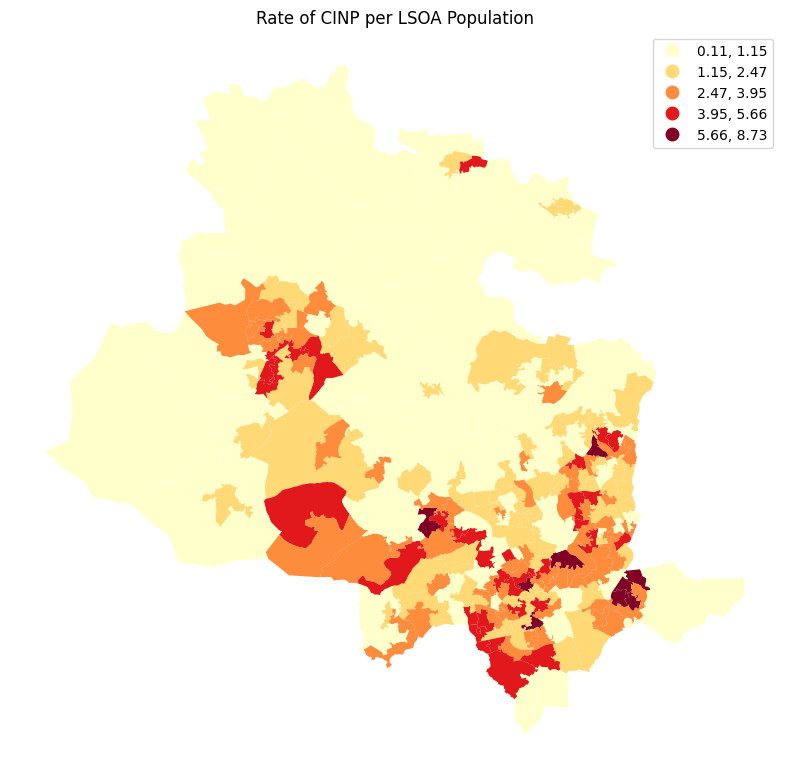

In [8]:
# Calculate intervention rates
cinp_rates = lah.calculate_intervention_rates(
    cinp,
    bradford_boundary_data,
    imd_data,
    population_data,
    intervention_name='CINP'
)

# Plot the intervention rate map
lah.plot_intervention_map(
    cinp_rates,
    intervention_name='CINP'
)

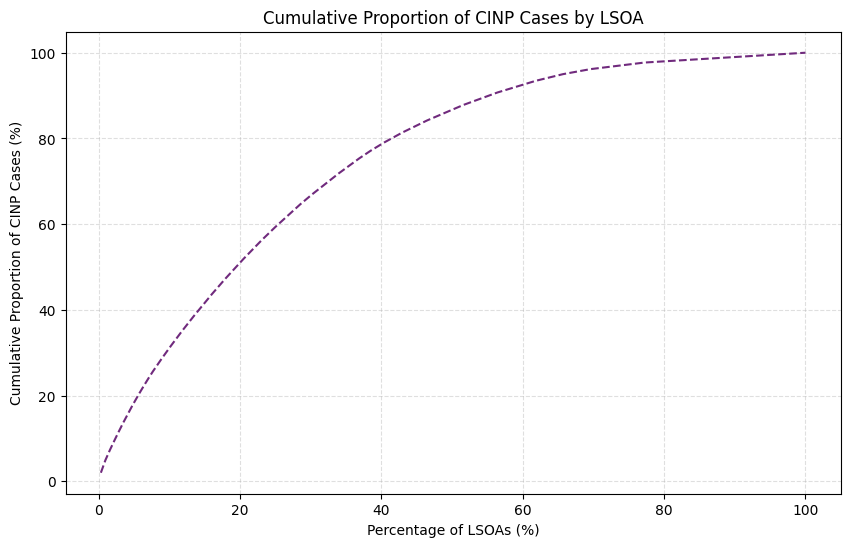

'19.2% of LSOAs account for 50% of CINP cases'

In [9]:
# Cumulative proportion plot
lah.plot_cumulative_distribution(
    cinp_rates,
    intervention_name='CINP'
)

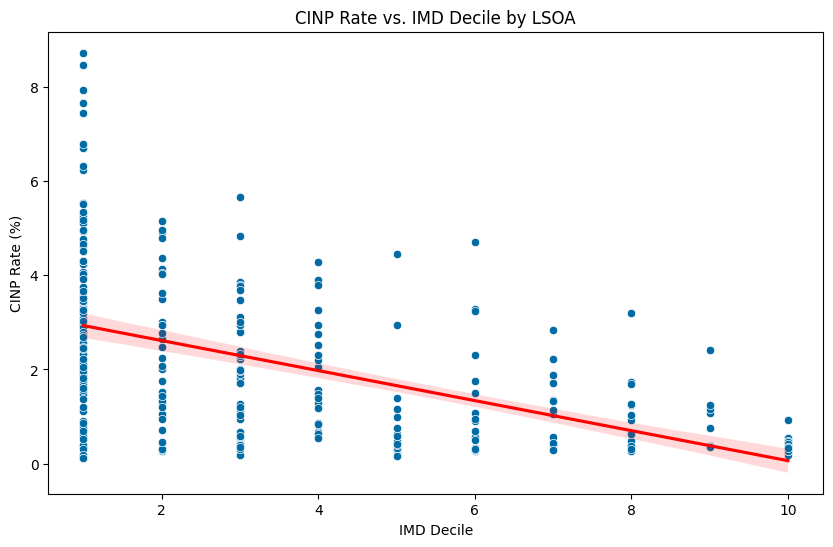


Statistical Analysis Results for CINP:
Pearson Correlation: -0.516 (p-value: 2.374e-22)

Linear Regression Results:
Slope: -0.318957
Intercept: 3.251
R-squared: 0.266
P-value: 2.374e-22


In [10]:
# Intervention rate vs IMD decile relationship
lah.analyze_imd_relationship(
    cinp_rates,
    intervention_name='CINP'
)

90th percentile cutoff value: 4.6063
Number of LSOAs above 90th percentile: 32
Number of children in high group (90th): 891
Number of children in other group (90th): 2210


80th percentile cutoff value: 3.5248
Number of LSOAs above 80th percentile: 63
Number of children in high group (80th): 1475
Number of children in other group (80th): 1626




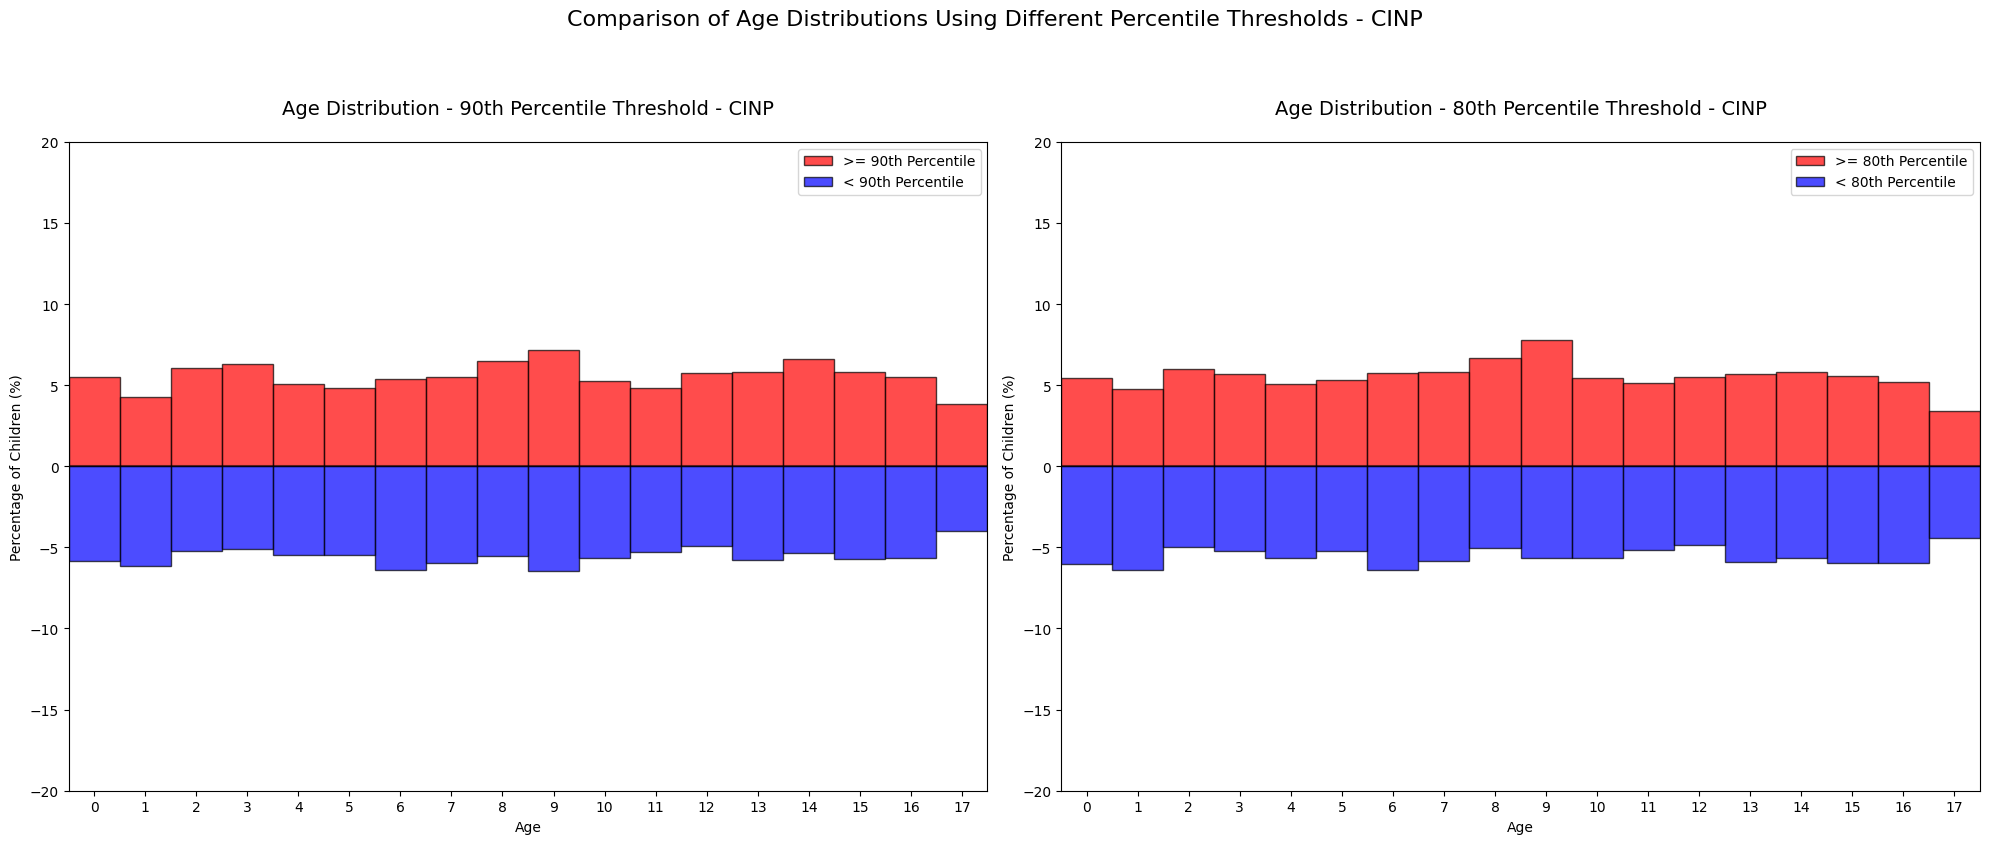

In [11]:
# Analyze age distribution
lah.analyze_age_distribution(
    merged_data,
    children_population,
    intervention_name='CINP',
    percentile_thresholds=[90, 80],
    age_column='age_at_entry'
)

90th percentile cutoff value: 4.6063
Number of LSOAs above 90th percentile: 32
Number of children in high group (90th): 891
Number of children in other group (90th): 2210


80th percentile cutoff value: 3.5248
Number of LSOAs above 80th percentile: 63
Number of children in high group (80th): 1475
Number of children in other group (80th): 1626




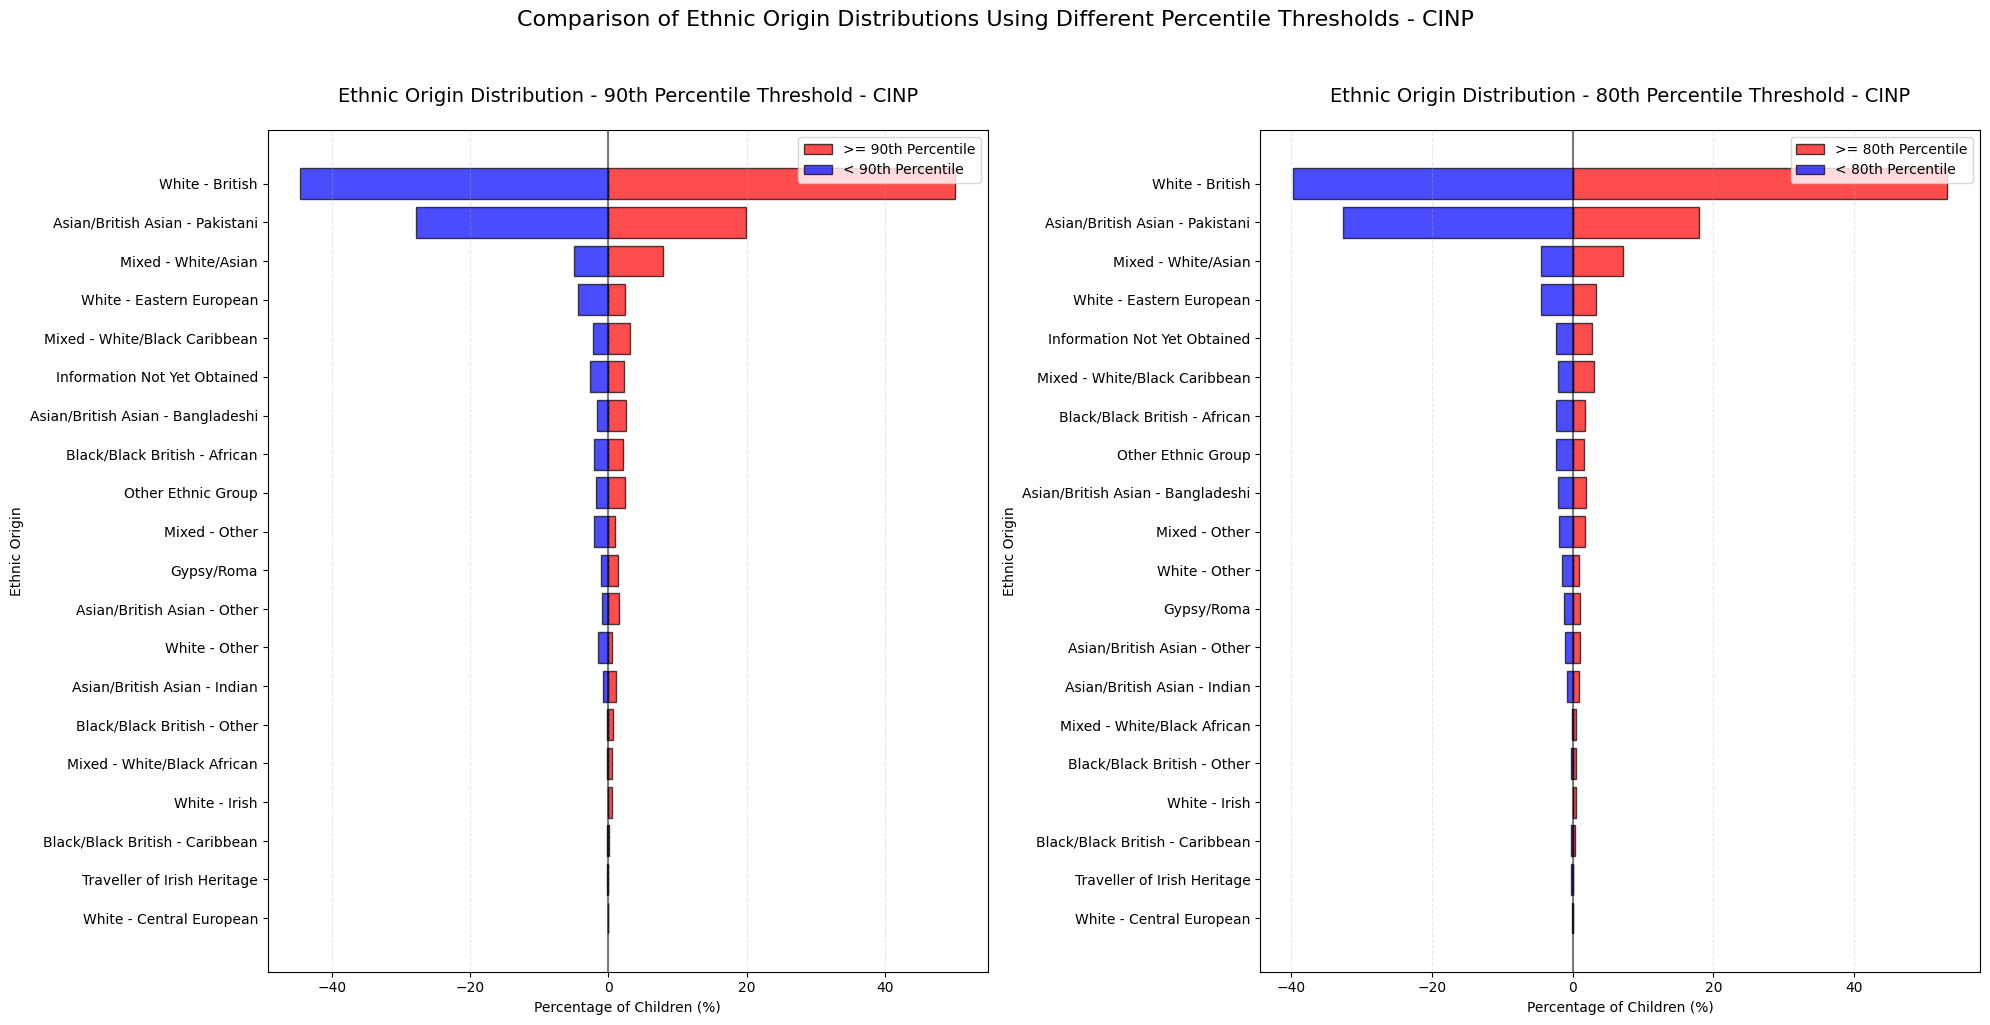

In [12]:
# Analyze ethnicity distribution
lah.analyze_ethnicity_distribution(
    merged_data,
    children_population,
    intervention_name='CINP',
    percentile_thresholds=[90, 80],
    ethnicity_column='EthnicOrigin'
)

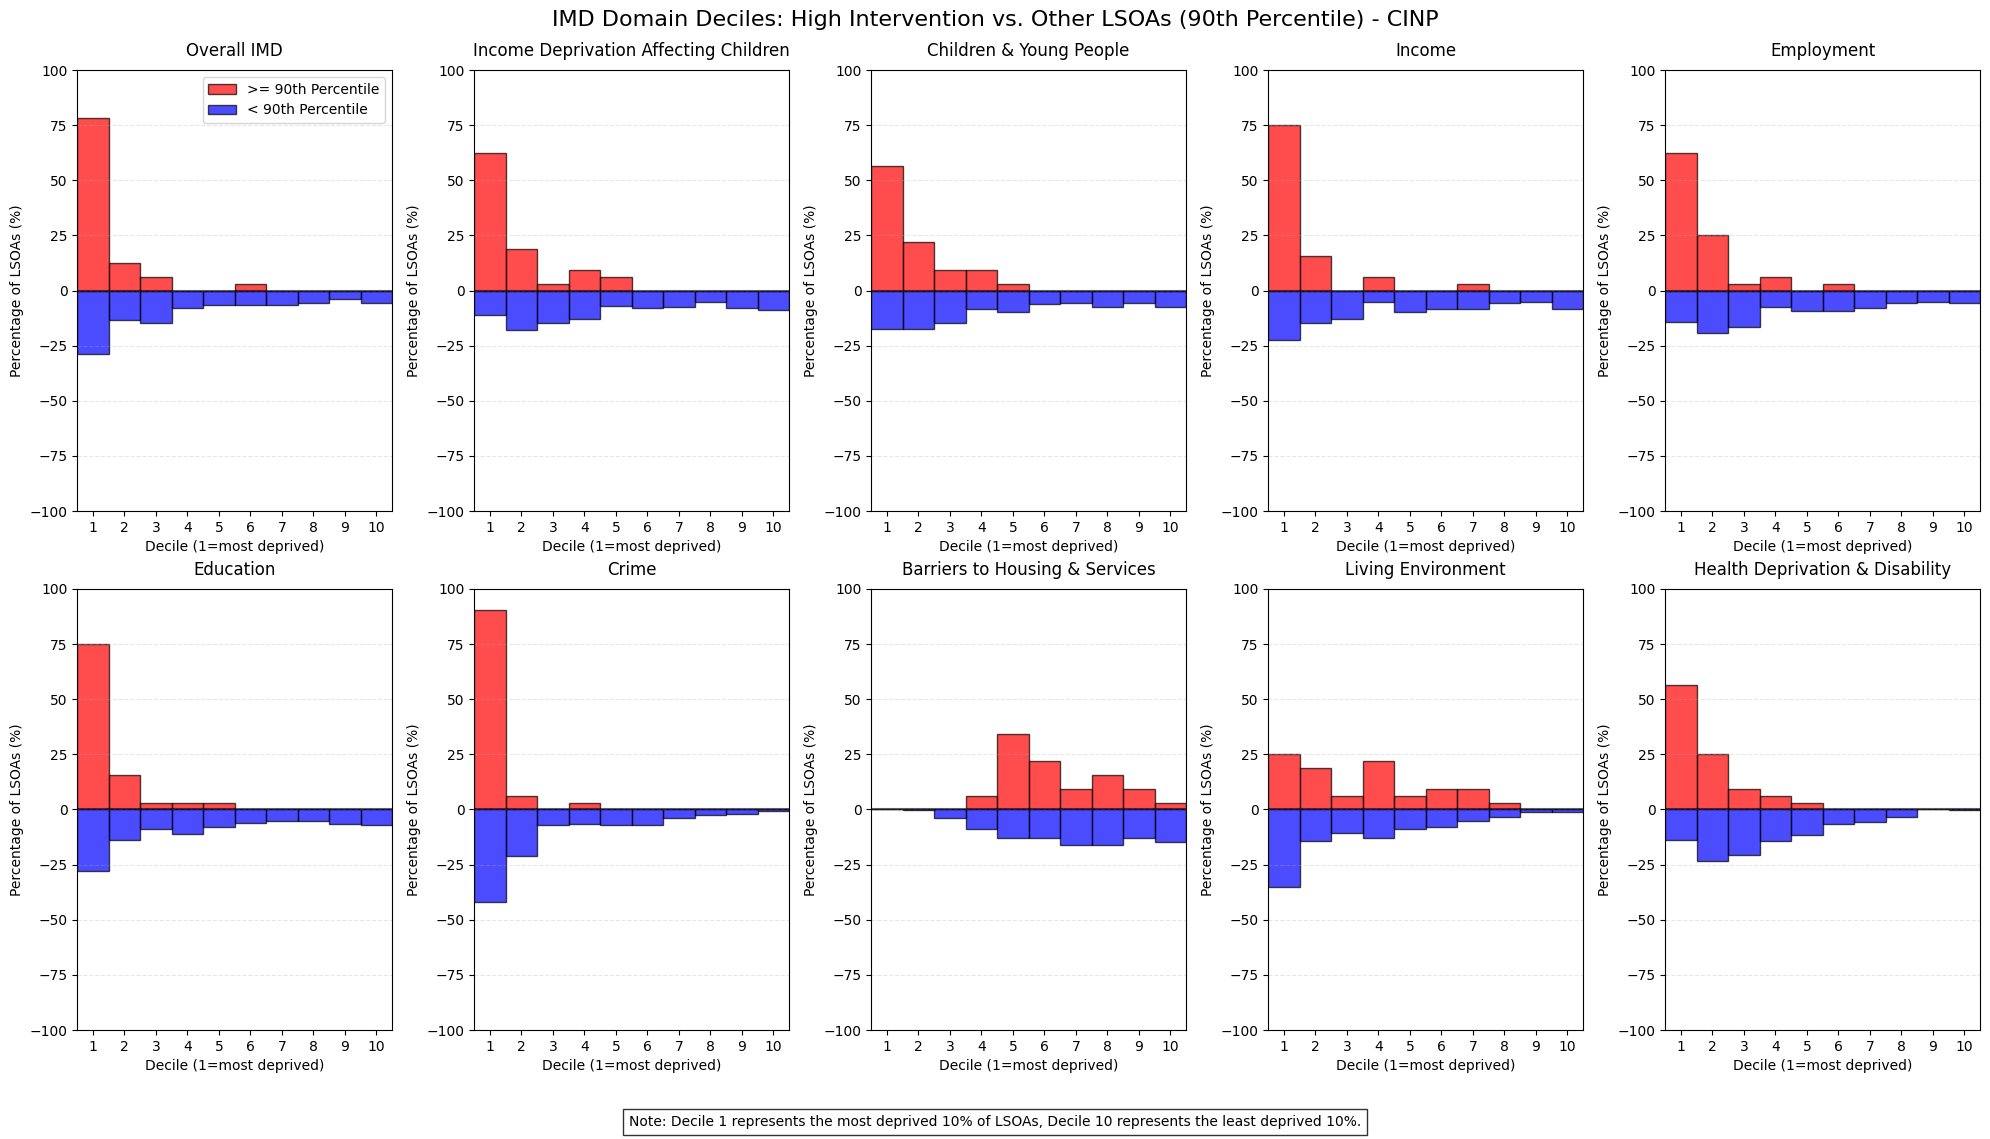

In [13]:
# Analyze IMD domains at 90th percentile
lah.analyze_imd_domains(
    children_population,
    percentile_threshold=90,
    intervention_name='CINP'
)

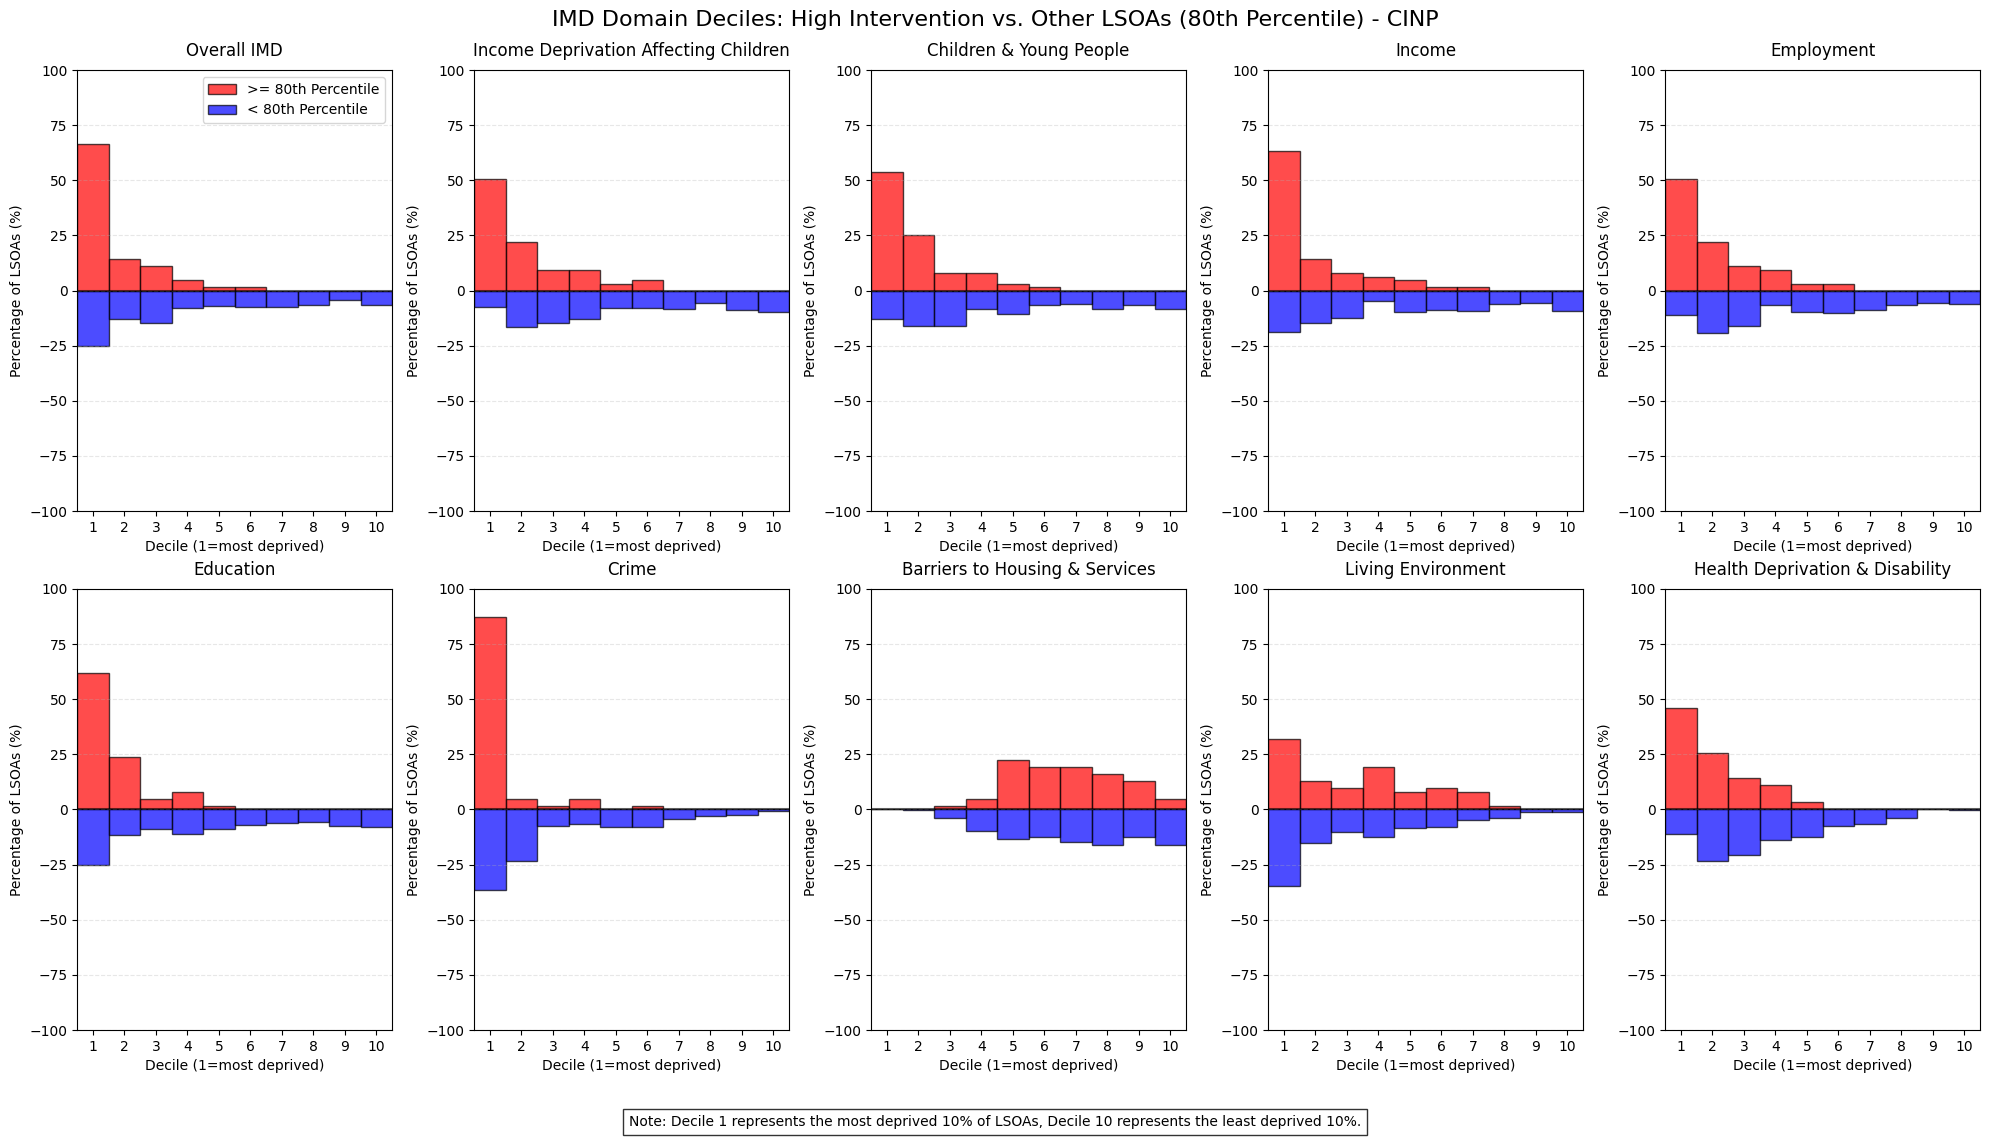

In [14]:
# Analyze IMD domains at 80th percentile
lah.analyze_imd_domains(
    children_population,
    percentile_threshold=80,
    intervention_name='CINP'
)